### **CARTPOLE DQN KERAS using Clases**

This is a naive version of the CARTPOLE DQN algorithm <br>
It converges in 65 episodes  <br>
In this version the agent has been created as a class making the code more compact <br>
This DQN Class can be used with other environments <br>
 <br>
Try to make it faster by doing some hyperparameter optimization  <br>
Try to explore less. Does it accelerates convergence?  <br>
Increasing the ROLLING_WINDOW it will converge slower but the Agent behavior will be more consistent

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


I0000 00:00:1738780844.294685   96125 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738780844.330652   96125 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738780844.330690   96125 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738780845.145404   96125 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1738780845.145455   96125 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

#### **Hyperparameters**

In [2]:

MAX_EPISODES = 300
ROLLING_WINDOW = 20
MEMORY_SIZE = 2000
MAX_STEPS = 500

gamma = 0.95                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.98
learning_rate = 0.001
batch_size = 64
solved_threshold = 195

verb = 0                             # to see traces (verbosity)

In [3]:
# Environment setup
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
class Agent_DQN():
    def __init__(self, states, actions, alpha, gamma, epsilon):
        self.nS = states
        self.nA = actions
        self.replay_buffer = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_NN()
        self.loss = []

    def build_NN(self):
        inputs = Input(shape=(state_size,), name="state_input")
        x = Dense(24, activation='relu', name="dense_1")(inputs)
        x = Dense(24, activation='relu', name="dense_2")(x)
        outputs = Dense(action_size, activation='linear', name="output_layer")(x)
        model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
        model.summary()
        return model

    def action(self, state):
        action_vals = self.model.predict(state, verbose=0) 
        return np.argmax(action_vals[0])
    
    def random_action(self):
        return random.randrange(self.nA) #Explore
    
    def sample_experiences(self, batch_size):
        indices = np.random.choice(len(self.replay_buffer), batch_size, replace=False)
        batch = [self.replay_buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards),
            np.vstack(next_states),
            np.array(dones, dtype=np.float32)
            )
    def store_experience(self, state, action, reward, next_state, done):             # memorize
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def experience_replay(self, batch_size, epsilon):
        if len(self.replay_buffer) < batch_size:
            return
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = self.sample_experiences(batch_size)

        target_qs = self.model.predict(states, verbose=verb)
        next_qs   = self.model.predict(next_states, verbose=verb)

        # Update target Q-values using standard Bellmanlike equation 
        target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)

        # Train the model on the Q-values
        self.model.fit(states, target_qs, epochs=1, verbose=0)
        return


In [5]:
# Support function
def select_action_greedy(state, agent_DQN):                                    
    if np.random.rand() <= epsilon:
        return agent_DQN.random_action()
    return agent_DQN.action(state) 

#### **Support Functions**

In [6]:
envCartPole = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = Agent_DQN(state_size, action_size, learning_rate, gamma, epsilon)

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
rewards_per_episode= []

done = False
rolling_avg = 0
rolling_avg_rewards = []

for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, agent)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        
        agent.experience_replay(batch_size, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:6.2f}, Steps: {step:3} Terminated: {done} ")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
#            model.save("lunarlander_ddqn_model1.keras")
        break

Episode:   1/300, Reward:  +29.00, Epsilon: 0.98, Rolling Avg:  29.00, Steps:  28 Terminated: True 
Episode:   2/300, Reward:  +30.00, Epsilon: 0.96, Rolling Avg:  29.50, Steps:  29 Terminated: True 
Episode:   3/300, Reward:  +24.00, Epsilon: 0.94, Rolling Avg:  27.67, Steps:  23 Terminated: True 
Episode:   4/300, Reward:  +13.00, Epsilon: 0.92, Rolling Avg:  24.00, Steps:  12 Terminated: True 
Episode:   5/300, Reward:  +18.00, Epsilon: 0.90, Rolling Avg:  22.80, Steps:  17 Terminated: True 
Episode:   6/300, Reward:  +17.00, Epsilon: 0.89, Rolling Avg:  21.83, Steps:  16 Terminated: True 
Episode:   7/300, Reward:  +13.00, Epsilon: 0.87, Rolling Avg:  20.57, Steps:  12 Terminated: True 
Episode:   8/300, Reward:  +12.00, Epsilon: 0.85, Rolling Avg:  19.50, Steps:  11 Terminated: True 
Episode:   9/300, Reward:  +16.00, Epsilon: 0.83, Rolling Avg:  19.11, Steps:  15 Terminated: True 
Episode:  10/300, Reward:  +14.00, Epsilon: 0.82, Rolling Avg:  18.60, Steps:  13 Terminated: True 


#### **Learning Plot and Episode Rewards**

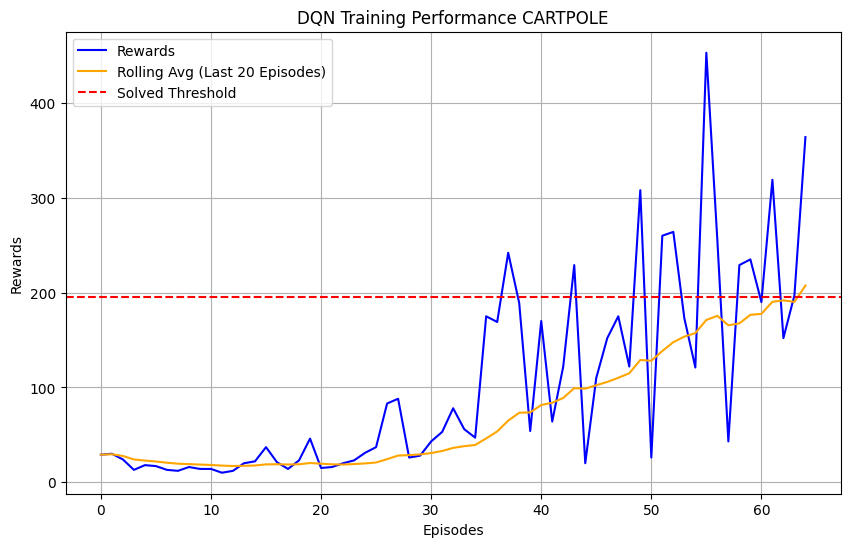

In [8]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last 20 Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance CARTPOLE')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [12]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action = agent.action(state)  # Predict action values


        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 212.00, Steps: 212
Test Episode:  2/10, Reward: 238.00, Steps: 238
Test Episode:  3/10, Reward: 292.00, Steps: 292
Test Episode:  4/10, Reward: 251.00, Steps: 251
Test Episode:  5/10, Reward: 280.00, Steps: 280
Test Episode:  6/10, Reward: 380.00, Steps: 380
Test Episode:  7/10, Reward: 222.00, Steps: 222
Test Episode:  8/10, Reward: 236.00, Steps: 236
Test Episode:  9/10, Reward: 255.00, Steps: 255
Test Episode: 10/10, Reward: 229.00, Steps: 229
Testing completed in 1.52 minutes


#### **Rendering 1 episode**

In [15]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action = agent.action(state)            # Predict action value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_Agent_DQN.gif')


Rendered Test Episode Reward: 223.00
Saved GIF to: ./CARTPOLE_Agent_DQN.gif


In [16]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-05 20:03
